# Segmentation


**Literature:**
* U-Net: https://arxiv.org/abs/1505.04597
* ResNet: https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf
* Torchvision ResNet implementation: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py


## Overview

This notebook offers keypoint detection as an example of an image-to-image tasks. We start by adapting a ResNet to produce dense (pixel-wise) output. Then this modified U-Net-style ResNet will be applied to a keypoint estimation problem.

### Libraries and Variables

In [1]:
import torch
from torch import nn
from torch.nn import functional as nnf
from torchvision.models import resnet18, ResNet18_Weights
from matplotlib import pyplot as plt
import numpy as np
from torchinfo import summary
import os
import json
from itertools import groupby
from os.path import join
from PIL import Image
from torchvision import transforms
os.environ['CUDA_VISIBLE_DEVICES'] = '2'


### Task Set 1: UNet and Loss

* Take a `ResNet18` network and add a decoder such that the network generates an output tensor having the same spatial extent as the input. Add **four skip concatenations** in the decoder: Use the ResNet18 activations after layer3, layer2, layer1 and finally the original input to the network.
* Pass dummy tensors (e.g. `torch.zeros()`) to the network to see if everything works.
* The cross entropy can be used for image-to-image tasks by applying it per-pixel. Use the tensors `a_pred` and `a_gt` to compute the cross-entropy (you can use PyTorch's cross_entropy function nnf.cross_entropy). Play around with the position of the predicted masks. What happens to the loss if the rectangles in the `a_pred` and the `a_gt` tensors overlap more and what happens if they overlap less?




In [2]:
rn18 = resnet18(weights=ResNet18_Weights.DEFAULT)
batch_size = 1
summary(rn18, input_size=(batch_size, 3, 224, 384))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 192]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 192]         128
├─ReLU: 1-3                              [1, 64, 112, 192]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 96]           --
├─Sequential: 1-5                        [1, 64, 56, 96]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 96]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 96]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 96]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 96]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 96]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 96]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 96]           --
│

In [3]:
for name, module in rn18.named_modules():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.relu
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample
layer4.0.downsample.0
layer4.0.downsample.1
layer4.1
layer4.1.conv1
layer4.1.bn1
layer4.1.relu
layer4.1.conv2
layer4.1.bn2
avgpool
fc


In [4]:
class DecoderBlock(nn.Module):

    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)

    def forward(self, x, skip_x):
        x_up = nnf.interpolate(x, size=(skip_x.size(2), skip_x.size(3)), mode='bilinear', align_corners=False)
        x = torch.cat([x_up, skip_x], dim=1)
        x = self.conv(x)

        x = nnf.relu(x)
        return x

class UNet(nn.Module):
    """
    decoder shape defines different factors for the number of maps in the decoder layers.
    """

    def __init__(self, resnet, resnet_layers=['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4'], encoder_sizes=[512, 256, 128, 64], decoder_sizes=(256, 128, 64, 64), outputs=5):
        super().__init__()

        self.resnet = resnet
        self.resnet_layers = resnet_layers
        self.decoder_sizes = decoder_sizes
        self.encoder_sizes = encoder_sizes

        self.decoder_names = ('decoder4', 'decoder3', 'decoder2', 'decoder1')
        self.decoder4 = DecoderBlock(self.encoder_sizes[0] + self.encoder_sizes[1], self.decoder_sizes[0])
        self.decoder3 = DecoderBlock(self.decoder_sizes[0] + self.encoder_sizes[2], self.decoder_sizes[1])
        self.decoder2 = DecoderBlock(self.decoder_sizes[1] + self.encoder_sizes[3], self.decoder_sizes[2])
        self.decoder1 = DecoderBlock(self.decoder_sizes[2] + 3, self.decoder_sizes[3]) # input channel size is 3 for rgb images
        self.post_conv = nn.Conv2d(self.decoder_sizes[3], outputs, (1, 1))

    def forward(self, x):
        activations = []
        activations.append(x)

        for layer in self.resnet_layers:
            x = getattr(self.resnet, layer)(x)
            if layer in ['layer1', 'layer2', 'layer3']:
                activations.append(x)

        decoder_activations = []
        for i, layer in enumerate(self.decoder_names):
            x = getattr(self, layer)(x, activations[-i-1])
            decoder_activations += [x]

        x = self.post_conv(x)

        return x, activations + decoder_activations

In [136]:
# test network with dummy input
dummy_inp = torch.randn(1, 3, 224, 384)
rn18 = resnet18(weights=ResNet18_Weights.DEFAULT)
model = UNet(rn18)

output = model(dummy_inp)
print(output[0].shape)

torch.Size([1, 5, 224, 384])


In [6]:
# define ground truth keypoint locations
a_gt = torch.zeros(224, 384, dtype=torch.int64)
a_gt[30:90, 110:170] = 1
a_gt[130:190, 110:170] = 2
a_gt[30:90, 210:270] = 3
a_gt[130:190, 210:270] = 4

def plot_example_tensors(a_pred: torch.Tensor, a_gt: torch.Tensor) -> None:
    """
    This function plots the prediction and the ground truth tensors. The prediction tensor has 3 channels, one for each class.
    The pixels with the highest value over all channels is plotted in the first subplot. The second subplot shows the ground truth.
    """
    _, ax = plt.subplots(1, 2)
    # The argmax(0) returns the highest value for each pixel over the 3 channels.
    # The result is a tensor of shape (H, W) with H height and W width 
    # where each value represents the channel index with the highest value.
    ax[0].imshow(a_pred.argmax(0))
    ax[1].imshow(a_gt)
    ax[0].set_title('Prediction')
    ax[1].set_title('Ground Truth')
    plt.show()

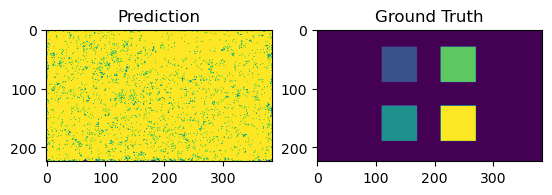

loss: 1.5763460397720337


In [7]:
plot_example_tensors(torch.squeeze(output[0]), a_gt)
print(f'loss: {nnf.cross_entropy(output[0].float(), a_gt[None, ...])}')

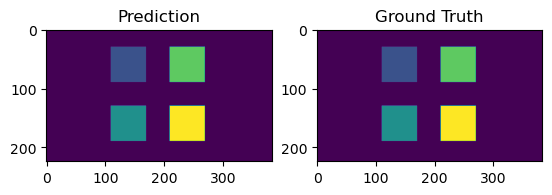

loss: 0.0


In [8]:
# Creates example tensors for the predictions and the ground truth (gt).
prediction = 100
a_pred = -prediction * torch.ones(5, 224, 384)
a_pred[0, ...] = prediction
a_pred[0, 30:90, 110:170] = -prediction
a_pred[0, 130:190, 110:170] = -prediction
a_pred[0, 30:90, 210:270] = -prediction
a_pred[0, 130:190, 210:270] = -prediction
a_pred[1, 30:90, 110:170] = prediction
a_pred[2, 130:190, 110:170] = prediction
a_pred[3, 30:90, 210:270] = prediction
a_pred[4, 130:190, 210:270] = prediction

plot_example_tensors(a_pred, a_gt)
print(f'loss: {nnf.cross_entropy(a_pred[None, ...].float(), a_gt[None, ...])}')

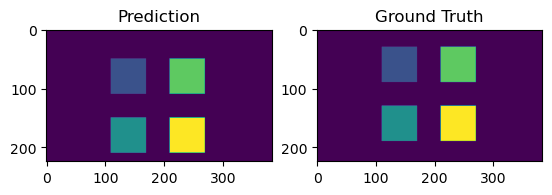

loss: 0.6558672785758972


In [9]:
# Creates example tensors for the predictions and the ground truth (gt).
prediction = 1
a_pred = -prediction * torch.ones(5, 224, 384)
a_pred[0, ...] = prediction
a_pred[0, 50:110, 110:170] = -prediction
a_pred[0, 150:210, 110:170] = -prediction
a_pred[0, 50:110, 210:270] = -prediction
a_pred[0, 150:210, 210:270] = -prediction
a_pred[1, 50:110, 110:170] = prediction
a_pred[2, 150:210, 110:170] = prediction
a_pred[3, 50:110, 210:270] = prediction
a_pred[4, 150:210, 210:270] = prediction

plot_example_tensors(a_pred, a_gt)
print(f'loss: {nnf.cross_entropy(a_pred[None, ...].float(), a_gt[None, ...])}')

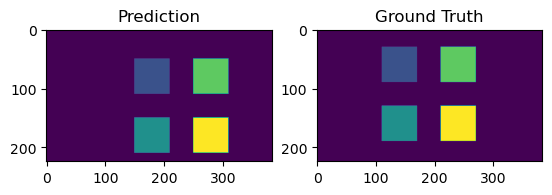

loss: 0.9534863233566284


In [10]:
# Creates example tensors for the predictions and the ground truth (gt).
prediction = 1
a_pred = -prediction * torch.ones(5, 224, 384)
a_pred[0, ...] = prediction
a_pred[0, 50:110, 150:210] = -prediction
a_pred[0, 150:210, 150:210] = -prediction
a_pred[0, 50:110, 250:310] = -prediction
a_pred[0, 150:210, 250:310] = -prediction
a_pred[1, 50:110, 150:210] = prediction
a_pred[2, 150:210, 150:210] = prediction
a_pred[3, 50:110, 250:310] = prediction
a_pred[4, 150:210, 250:310] = prediction

plot_example_tensors(a_pred, a_gt)
print(f'loss: {nnf.cross_entropy(a_pred[None, ...].float(), a_gt[None, ...])}')

### Task Set 2: Keypoints

* Explore the keypoint annotations (`annotations.json`). What information is contained in them?
* Visualize the keypoints by overlaying them on some images.

* Create a `KeypointsDataset` class. The getitem function should return images and corresponding keypoint maps of size 224x384. Enhance the keypoints to a circle of radius 3. Note that the keypoints are not always visible. Only include the visible keypoints. The keypoints are given as a list. Starting from the first element, every third element is the x-coordinate of one keypoint, starting from the second element, every third element is the y-coordinate of one keypoint, and starting from the third element, every third element encodes the visibility of the keypoint with 0 meaning that the keypoint is not in the image, 1 that the keypoint is in the image, but covered, and 2 that the keypoint is visible. In other words, starting from the first element in the list, every triple describes one of the image's keypoints.
* Train a UNet on the keypoint maps using the cross-entropy loss.
* If you use a pre-trained ResNet18, make sure your data uses the same normalization (implemented in the `KeypointsDataset`) as the pre-training.

* Compare the predictions of your model visually with the ground truth.
* Try out different decoder sizes. Does it have an influence on the performance?


In [5]:
data_dir = '../../data/keypoint_detection'
images_dir = join(data_dir, 'images')
pig_kp = json.load(open(join(data_dir, 'annotations.json')))
annotations = pig_kp['annotations']
print('keys of each annotation:', annotations[0].keys())

keys of each annotation: dict_keys(['id', 'image_id', 'category_id', 'keypoints', 'bbox', 'area', 'iscrowd', 'segmentation', 'num_keypoints'])


In [6]:
annotations[0]['keypoints']

[148.475,
 148.52962962962962,
 2,
 150.725,
 164.86296296296297,
 2,
 138.6239990234375,
 158.58919270833334,
 2,
 103.3739990234375,
 166.36697048611111,
 2]

In [7]:
pig_kp['categories']

[{'id': 1,
  'name': 'pig',
  'keypoints': ['left_ear', 'right_ear', 'neck', 'hip'],
  'skeleton': []}]

In [8]:
# Some images do not annotations and some annotations do not contain any keypoints. These are filtered in the following.

# filter out empty annotations
anns = pig_kp['annotations']
anns = [a for a in anns if len([v for v in a['keypoints'][2::3] if v==2]) > 0]

# create annotations by image_id and annotation id
images = list(set([a['image_id'] for a in anns]))
anns = sorted(anns, key=lambda x:x['image_id'])
anns_by_image = {k: [a['id'] for a in v] for k,v in groupby(anns, lambda x: x['image_id'])}
anns_by_id = {a['id']: a for a in anns}

# create images by id
images_by_id = {img['id']: img for img in pig_kp['images']}

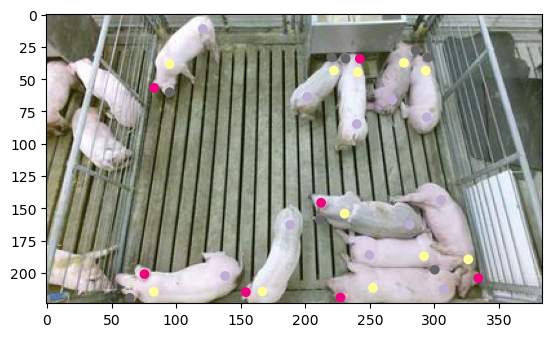

In [14]:
def visualize_keypoints(annotations, images_dir, image_id):
    
    for i in range(len(annotations)):
        ann = annotations[i]
        if not ann["image_id"] == image_id:
            continue

        kp = np.array(ann['keypoints'])
        filename = join(images_dir, images_by_id[ann["image_id"]]['file_name'])

        x = kp[0::3]
        y = kp[1::3]
        v = kp[2::3]

        c = np.array([plt.cm.Accent_r(i/len(x)) for i in range(len(x))])
        if len(x[v>1]) > 0:
            plt.scatter(x[v>1], y[v>1], facecolor=c[v>1])

    plt.imshow(np.array(Image.open(filename)))
    plt.show()

visualize_keypoints(annotations, images_dir, 100)

In [76]:
import torch
from skimage.draw import disk

def get_samples(anns_by_image, anns_by_id, images_by_id, images_dir, img_ids):
    samples = []

    for img_id, ann_ids in anns_by_image.items():
        if not img_id in img_ids:
            continue
        filename = join(images_dir, images_by_id[img_id]['file_name'])

        img = Image.open(filename)
        img_w, img_h = images_by_id[img_id]['width'], images_by_id[img_id]['height']
        labels = np.zeros((img_h, img_w), 'uint8')    

        for ann_id in ann_ids:

            ann = anns_by_id[ann_id]
            kp = np.array(ann['keypoints']).astype('float32')
            x = kp[0::3]
            y = kp[1::3]
            v = kp[2::3]

            for i in range(4):
                if v[i] == 2:
                    rr, cc = disk((y[i], x[i]), 3, shape=(img_h, img_w))
                    labels[rr, cc] = i+1       


        labels = Image.fromarray(labels.astype('int8'))
        samples += [(img, labels)]
    
    return samples



class KeypointsDataset(object):
    
    def __init__(self, samples):
        self.samples = samples
        
    def transform(self, img, labels):
        
        # Convert to tensor
        img = transforms.ToTensor()(img)
        labels = transforms.ToTensor()(labels)

        normalize = transforms.Normalize(mean=torch.tensor([0.485, 0.456, 0.406]),
                                         std=torch.tensor([0.229, 0.224, 0.225]))
        img = normalize(img)

        return img, labels.squeeze()

    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, i):
        sample = self.samples[i]
        img, labels = sample
        img, labels = self.transform(img, labels)
        return img, labels



samples_train = get_samples(anns_by_image, anns_by_id, images_by_id, images_dir, range(1, 2001))
# samples_train = get_samples(anns_by_image, anns_by_id, images_by_id, images_dir, range(1, 5))
trainset = KeypointsDataset(samples_train)
samples_val = get_samples(anns_by_image, anns_by_id, images_by_id, images_dir, range(2001, 2101))
valset = KeypointsDataset(samples_val)

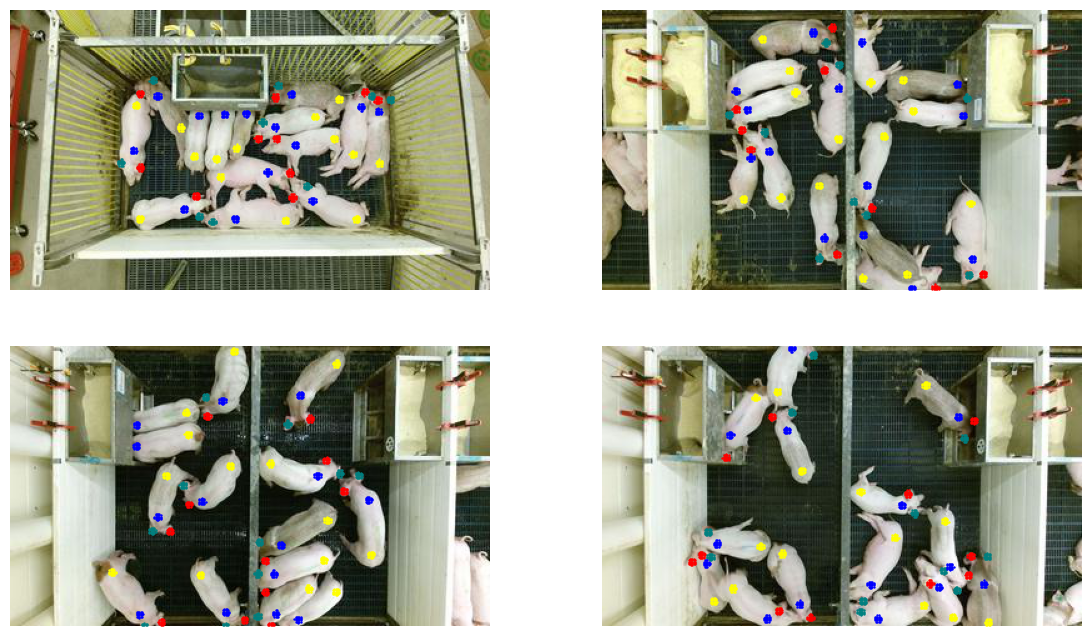

In [77]:
# visualize some samples from KeypointsDataset
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
for i, ax in enumerate(axes.flatten()):
    img, labels = trainset[i]
    # img = img * torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    # img = img + torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    ax.imshow(img.permute([1, 2, 0]))
    
    colors = ['red', 'teal', 'blue', 'yellow']
    for j in range(1, 5):
        y, x = torch.where(labels == j)
        ax.scatter(x.numpy(), y.numpy(), c=colors[j-1], s=0.5)  # Plot keypoints
    ax.axis('off')

In [88]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm


epochs = 50


loader = DataLoader(trainset, batch_size=64, shuffle=True)
rn18 = resnet18(weights=ResNet18_Weights.DEFAULT)
model = UNet(rn18, outputs=5).cuda()
losses = []

opt = Adam(model.parameters(), lr=0.001)

for i_epoch in tqdm(range(epochs)):
    for data_x, data_y in loader:
        
        data_x = data_x.float().cuda()
        data_y = data_y.long().cuda()
        pred, _ = model(data_x)

        opt.zero_grad()

        loss = nnf.cross_entropy(pred, data_y)
        loss.backward()
        
        opt.step()
        
        losses += [float(loss)]
        
    # print(f'loss: {np.mean(losses)}')
        

100%|██████████| 50/50 [09:26<00:00, 11.33s/it]


In [90]:
losses[-1]

0.018338089808821678

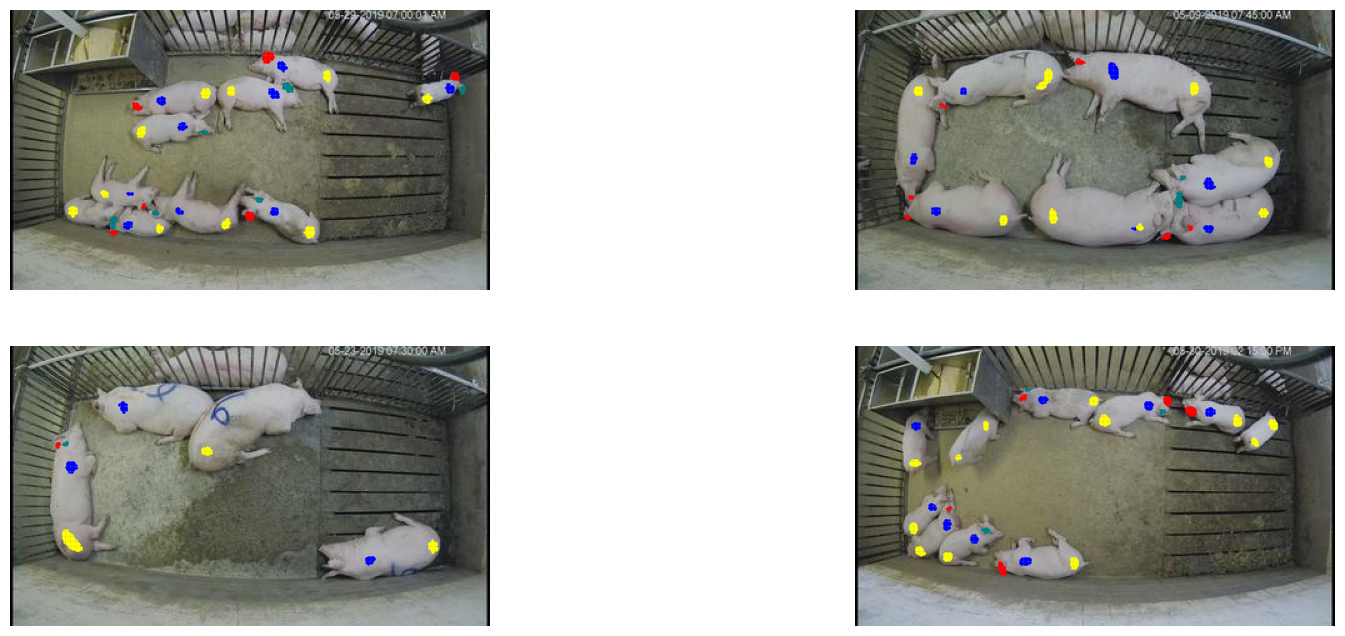

In [91]:
# visualize preds
# 'left_ear', 'right_ear', 'neck', 'hip'
import torch

model.eval()  
threshold = 0.9

fig, axes = plt.subplots(2, 2, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()):
    img, _ = valset[i]
    # img, _ = trainset[i]
    
    with torch.no_grad():
        # logits, _ = model(img.unsqueeze(0).cuda())
        logits, _ = model(img.unsqueeze(0).cuda())
        logits = logits.squeeze()
        probabilities = torch.sigmoid(logits)

    # plot
    # img = img * torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    # img = img + torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    ax.imshow(img.permute([1, 2, 0]))
    
    colors = ['red', 'teal', 'blue', 'yellow']
    argmaxs = torch.argmax(probabilities, 0)
    
    for ch in range(probabilities.shape[0]):
        if ch == 0:
            continue

        y, x = torch.where(argmaxs == ch)  # Get positions where probability exceeds threshold
        ax.scatter(x.cpu().numpy(), y.cpu().numpy(), c=colors[ch-1], s=0.5)  # Plot keypoints

    ax.axis('off')


In [57]:
torch.argmax(torch.randn(5, 10, 10), 0).shape

torch.Size([10, 10])